In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from dataclasses import dataclass

2024-05-12 21:08:24.901013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 21:08:24.901114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 21:08:25.161277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED_VALUE = 42
DIR = "."
IMAGE_DIR = os.path.join(DIR, "visuals")
MODEL_DIR = os.path.join(DIR, "models")

if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    
plt.rcParams['figure.facecolor'] = 'beige'
plt.rcParams['axes.titlecolor'] = 'seagreen'
plt.rcParams['axes.titlesize'] = 12

np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [15]:
train_set, valid_set, test_set = tfds.load('malaria', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                           as_supervised=True)
info = tfds.builder("malaria").info

In [16]:
def save_fig(name, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_DIR, name + '.' + fig_extension)
    print(f"Saving figure {name}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def save_model(model, name:str=None):
    model_path = os.path.join(MODEL_DIR, name)
    print(f"Saving model {name}")
    model.save(model_path)

Saving figure smear


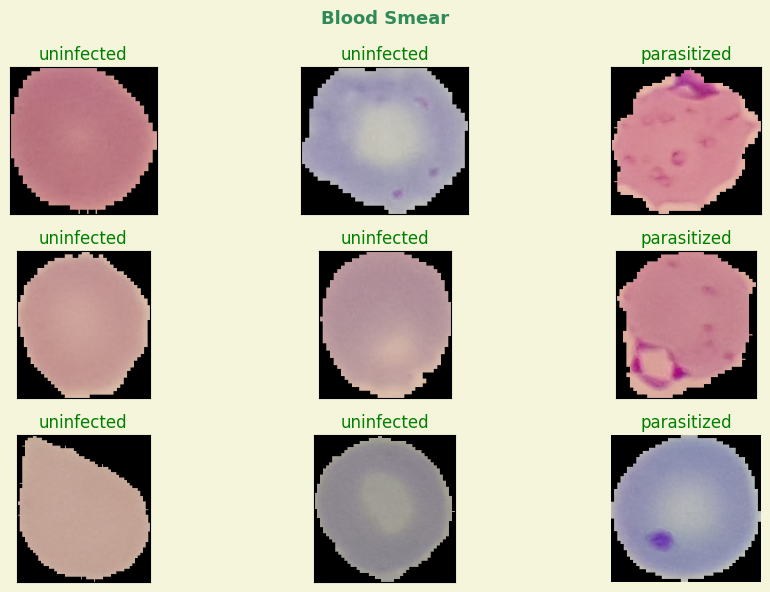

In [17]:
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_set.take(9)):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_title(f"{info.features['label'].int2str(label)}", color='g')
plt.suptitle("Blood Smear", weight='bold', color='seagreen', size=13)
plt.axis('off')
plt.grid(True)
save_fig("smear")
plt.show()

### Preprocessing.

In [18]:
@dataclass(frozen=True)
class DataConfig():
    IMG_HEIGHT:    int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainConfig:
    BATCH_SIZE:    int = 32
    EPOCHS:        int = 31
    LEARNING_RATE: float = 0.0001
    DROPOUT:       float = 0.4
    BUFFER_SIZE:   int = 1000

In [19]:
for image, label in train_set.take(5):
    print(image.shape[0:2])

(103, 103)
(106, 121)
(139, 142)
(130, 118)
(121, 109)


In [20]:
def preprocess_dataset(dataset: tf.data.Dataset, shuffle_dataset=False, augment=False, hsv=False):
    def preprocess_image(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH))
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        if hsv:
            image = tf.image.random_hue(image, 0.08)
            image = tf.image.random_saturation(image, 0.6, 1.6)
            image = tf.image.random_brightness(image, 0.05)
            image = tf.image.random_contrast(image, 0.7, 1.3)
        return image, label
    
    ds = dataset.cache()
    ds = ds.map(preprocess_image)
    ds = ds.batch(TrainConfig.BATCH_SIZE)
    if shuffle_dataset:
        ds = ds.shuffle(buffer_size=TrainConfig.BUFFER_SIZE, reshuffle_each_iteration=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [21]:
train_ds = preprocess_dataset(train_set, shuffle_dataset=True, augment=True, hsv=True)
valid_ds = preprocess_dataset(valid_set, augment=True, hsv=True)
test_ds = preprocess_dataset(valid_set, augment=True, hsv=True)

Saving figure processed


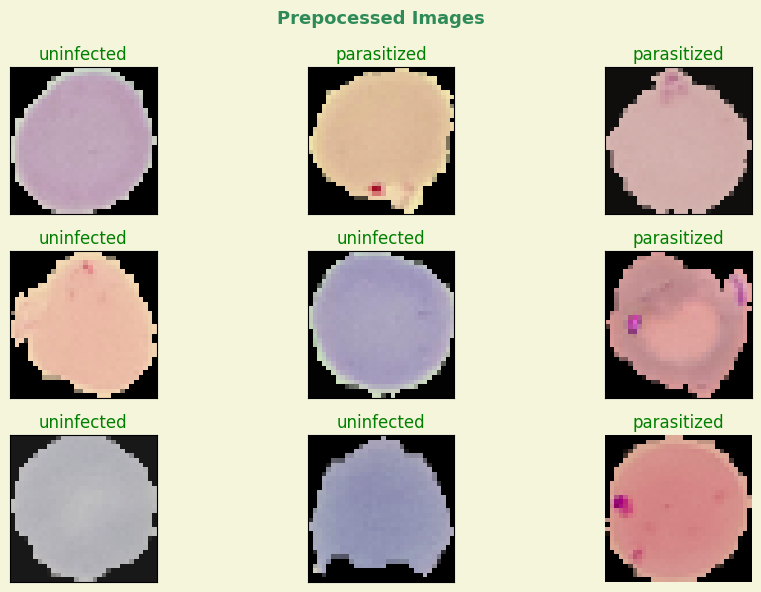

In [22]:
image_batch, label_batch = next(iter(train_ds))
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(zip(image_batch, label_batch)):
    if i >= 9:
        break
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_title(f"{info.features['label'].int2str(label)}", color='g')
plt.suptitle("Prepocessed Images", weight='bold', color='seagreen', size=13)
plt.axis('off')
plt.grid(True)
save_fig("processed")
plt.show()

In [23]:
for image, label in train_ds.take(1):
  print(image.shape[1:3])

(32, 32)


### Model Definition.
- A custom convolutional network inspired by the vgg16.

In [24]:
def custom_cnn(input_shape=(DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH, DataConfig.NUM_CHANNELS)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [25]:
model = custom_cnn()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,737 (2.54 MB)

 Trainable params: 664,737 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compiling and Training.

In [26]:
model.compile(optimizer=Adam(learning_rate=TrainConfig.LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
history = model.fit(train_ds,
                    batch_size=TrainConfig.BATCH_SIZE,
                    epochs=TrainConfig.EPOCHS,
                    validation_data=valid_ds,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/31
 45/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5415 - loss: 0.6907

I0000 00:00:1715548592.981926     171 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715548593.005663     171 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


527/689 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5953 - loss: 0.6645

W0000 00:00:1715548597.433791     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


676/689 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6097 - loss: 0.6517

W0000 00:00:1715548598.914060     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6111 - loss: 0.6503 - val_accuracy: 0.8451 - val_loss: 0.3521
Epoch 2/31


W0000 00:00:1715548601.202298     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9058 - loss: 0.2614 - val_accuracy: 0.9394 - val_loss: 0.1888
Epoch 3/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9461 - loss: 0.1659 - val_accuracy: 0.9445 - val_loss: 0.1674
Epoch 4/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9476 - loss: 0.1519 - val_accuracy: 0.9507 - val_loss: 0.1541
Epoch 5/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9535 - loss: 0.1404 - val_accuracy: 0.9503 - val_loss: 0.1507
Epoch 6/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9549 - loss: 0.1364 - val_accuracy: 0.9525 - val_loss: 0.1425
Epoch 7/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9581 - loss: 0.1237 - val_accuracy: 0.9528 - val_loss: 0.1448
Epoch 8/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9617 - loss: 0.1140 - val_accuracy: 0.9510 - val_loss: 0.1419
Epoch 9/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9611 - loss: 0.1147 - val_accuracy: 0.9474 - val_

In [29]:
def plot_results(metrics, metric_name=None, title=None, ylabel=None, ylim=None, xlim=None, color=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics]
        metric_name = [metric_name]
    
    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title(title, pad=10.0, weight='bold', color='magenta')

    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    plt.grid(True)
    plt.legend(metric_name)
    save_fig(title)
    plt.show()
    plt.close()

Saving figure CNN Accuracy


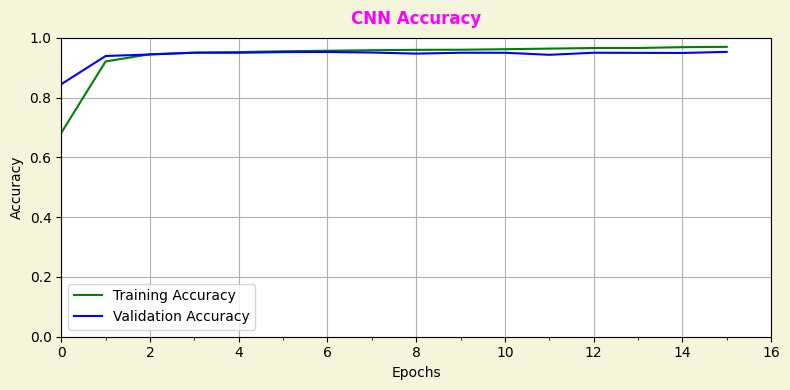

Saving figure CNN Loss


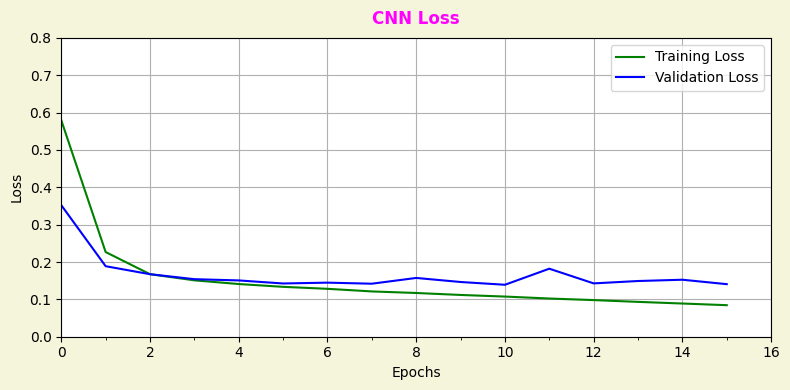

In [30]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plot_results([train_acc, val_acc],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             ylabel="Accuracy", ylim=[0.0, 1.0], xlim=[0, 16],
             title="CNN Accuracy", color=['g', 'b'])

plot_results([train_loss, val_loss],
             metric_name=['Training Loss', 'Validation Loss'],
             ylabel="Loss", ylim=[0.0, 0.8], xlim=[0, 16],
             title="CNN Loss", color=['g', 'b'])

### Model Evaluation.

In [31]:
results = model.evaluate(test_ds)
print(f"Prediction accuracy: {results[1] * 100:.3f}%")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9488 - loss: 0.1494
Prediction accuracy: 95.029%


In [32]:
def evaluate_model(dataset: tf.data.Dataset, model, rows: int=3, cols: int=5, fig_name:str="eval_results"):
    class_names = ['parasitized', 'uninfected']

    image_batch, label_batch = next(iter(dataset))
    predictions = model.predict(image_batch)

    plt.figure(figsize=(15, 10))
    matches = 0

    for idx in range(min(len(image_batch), rows * cols)):
        ax = plt.subplot(rows, cols, idx+1)
        plt.axis('off')
        plt.imshow(image_batch[idx])

        pred_idx = int(tf.round(predictions[idx]).numpy())
        truth_idx =  int(label_batch[idx].numpy())

        title = str(class_names[truth_idx]) + ":" + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize': 14})
        if pred_idx == truth_idx:
            matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
        
        acc = matches / (idx+1)
    print(f"Prediction accuracy: {int(acc * 100)/100}")
    save_fig(fig_name)
    
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Prediction accuracy: 0.86
Saving figure eval_results_v_1_0


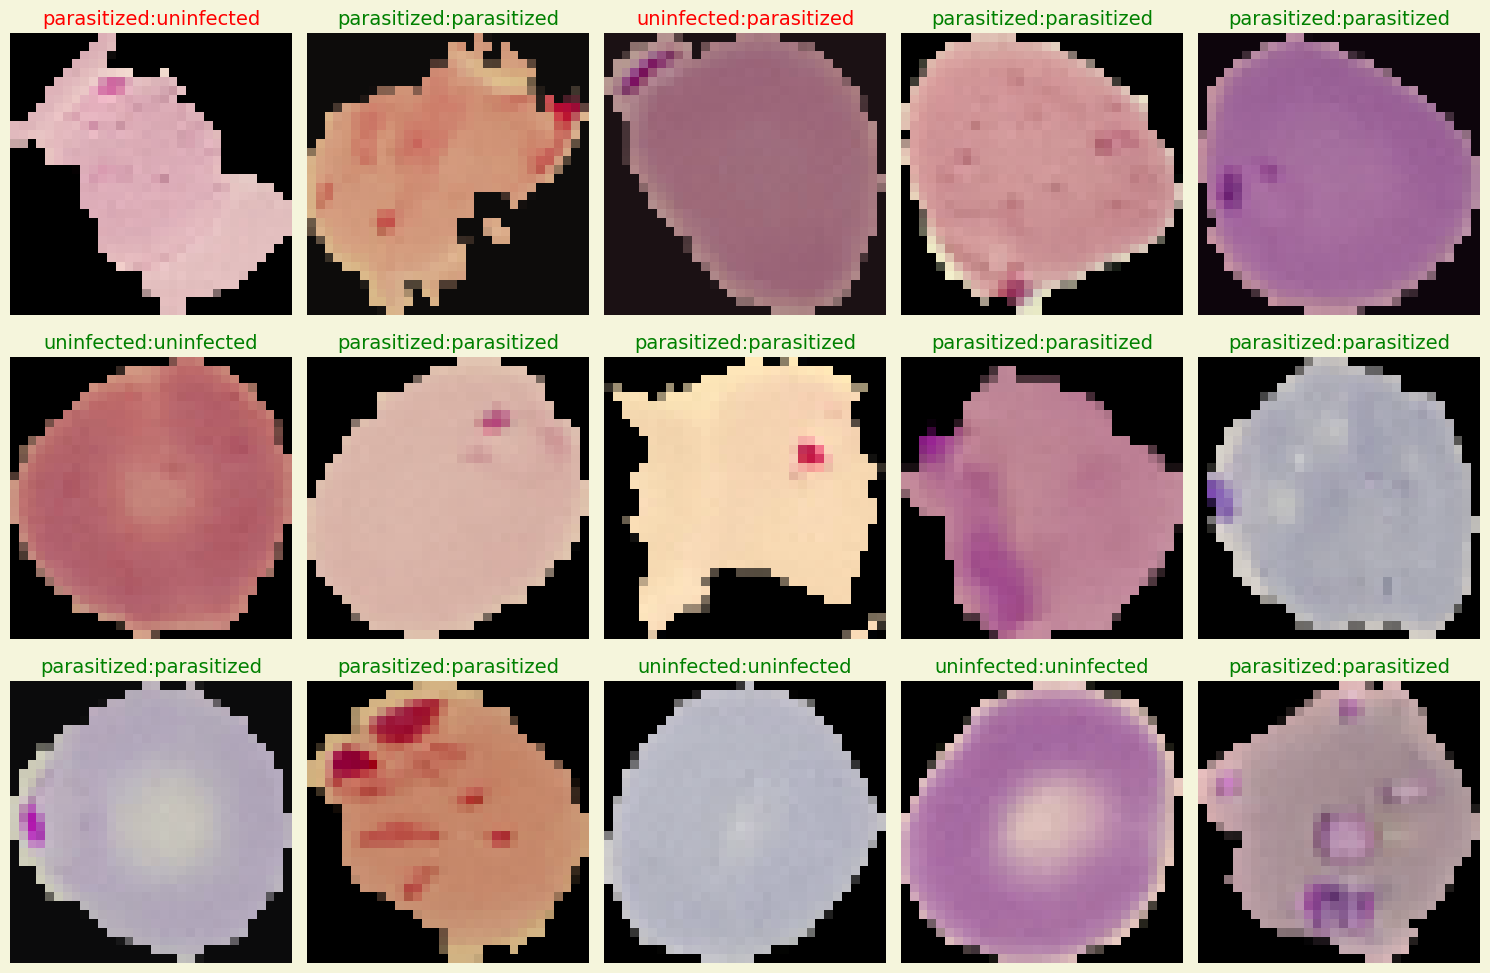

In [33]:
evaluate_model(test_ds, model, fig_name="eval_results_v_1_0")

- Confusion Matrix.

In [34]:
predicted = model.predict(test_ds)
predicted_labels = [1 if prob >= 0.5 else 0 for prob in predicted]

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Saving figure confusion matrix_v.1.0


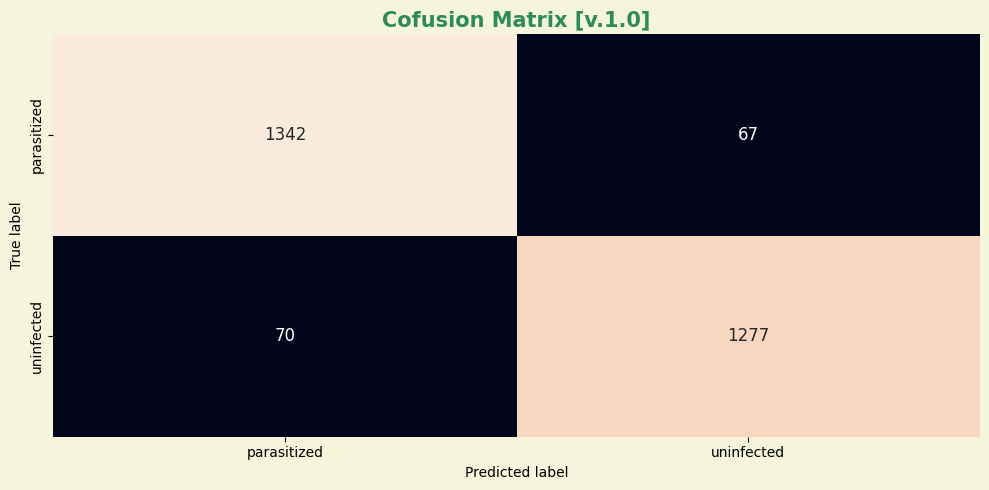

In [37]:
class_names = info.features['label'].names
ground_truth_labels = []

for image_batch, label_batch in test_ds:
    for label in label_batch:
        ground_truth_labels.append(label.numpy())
        
ground_truth = np.array(ground_truth_labels)

cm = tf.math.confusion_matrix(labels=ground_truth, predictions=predicted_labels)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d',cbar=False, annot_kws={"size": 12},
           xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Cofusion Matrix [v.1.0]", weight='bold', size=15, color='seagreen')
save_fig("confusion matrix_v.1.0")
plt.show()

In [38]:
save_model(model, "malaria_v_1_0.h5")

Saving model malaria_v_1_0.h5


### Model --> Add Dropout.
- Add dropout layer to the custom cnn.

In [39]:
def custom_cnn_drop(input_shape=(DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH, DataConfig.NUM_CHANNELS)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [69]:
drop_model = custom_cnn_drop()
drop_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,737 (2.54 MB)

 Trainable params: 664,737 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
drop_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [71]:
train_ds = preprocess_dataset(train_set, shuffle_dataset=True, augment=True, hsv=True)
valid_ds = preprocess_dataset(valid_set, augment=True, hsv=True)
test_ds = preprocess_dataset(valid_set, augment=True, hsv=True)

In [72]:
drop_history = drop_model.fit(train_ds,
                              batch_size=TrainConfig.BATCH_SIZE,
                              epochs=TrainConfig.EPOCHS,
                              validation_data=valid_ds,
                              verbose=1)

Epoch 1/31
 28/689 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5296 - loss: 0.6934 

W0000 00:00:1715550430.634678     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/689 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5106 - loss: 0.6938

W0000 00:00:1715550438.312334     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5104 - loss: 0.6938

W0000 00:00:1715550439.529913     171 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5104 - loss: 0.6938 - val_accuracy: 0.4888 - val_loss: 0.6939
Epoch 2/31


W0000 00:00:1715550440.724757     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5258 - loss: 0.6814 - val_accuracy: 0.9445 - val_loss: 0.2504
Epoch 3/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9358 - loss: 0.2066 - val_accuracy: 0.9510 - val_loss: 0.1701
Epoch 4/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9465 - loss: 0.1632 - val_accuracy: 0.9459 - val_loss: 0.1860
Epoch 5/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9489 - loss: 0.1600 - val_accuracy: 0.9521 - val_loss: 0.1709
Epoch 6/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9489 - loss: 0.1583 - val_accuracy: 0.9543 - val_loss: 0.1471
Epoch 7/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9530 - loss: 0.1479 - val_accuracy: 0.9528 - val_loss: 0.1504
Epoch 8/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9507 - loss: 0.1470 - val_accuracy: 0.9510 - val_loss: 0.1522
Epoch 9/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9547 - loss: 0.1419 - val_accuracy: 0.9514 - val

Saving figure CNN Dropout Acc


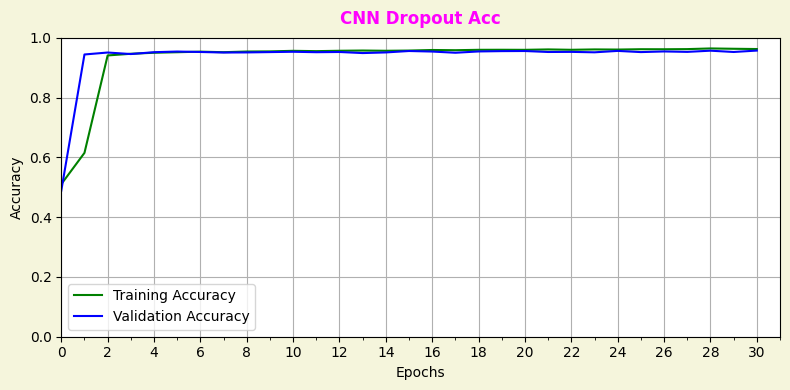

Saving figure CNN Dropout Loss


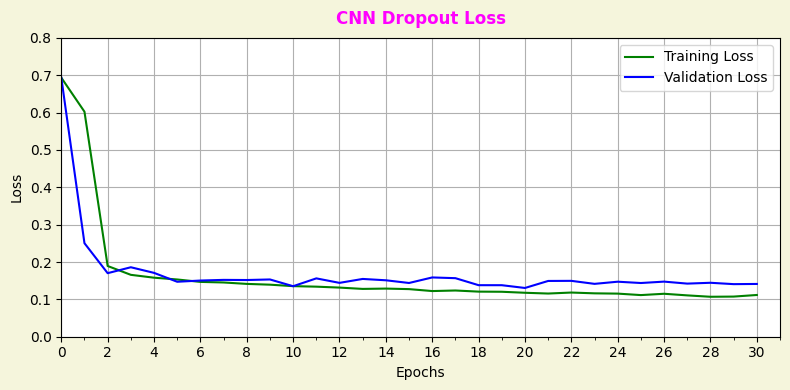

In [73]:
train_acc = drop_history.history["accuracy"]
train_loss = drop_history.history["loss"]
val_acc = drop_history.history["val_accuracy"]
val_loss = drop_history.history["val_loss"]

plot_results([train_acc, val_acc],
             metric_name=['Training Accuracy', 'Validation Accuracy'],
             ylabel="Accuracy", ylim=[0.0, 1.0], xlim=[0, 31],
             title="CNN Dropout Acc", color=['g', 'b'])

plot_results([train_loss, val_loss],
             metric_name=['Training Loss', 'Validation Loss'],
             ylabel="Loss", ylim=[0.0, 0.8], xlim=[0, 31],
             title="CNN Dropout Loss", color=['g', 'b'])

### Model Evaluation.

In [74]:
test_loss, test_acc = drop_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.3f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9599 - loss: 0.1367
Test accuracy: 95.755


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Prediction accuracy: 0.93
Saving figure eval_results


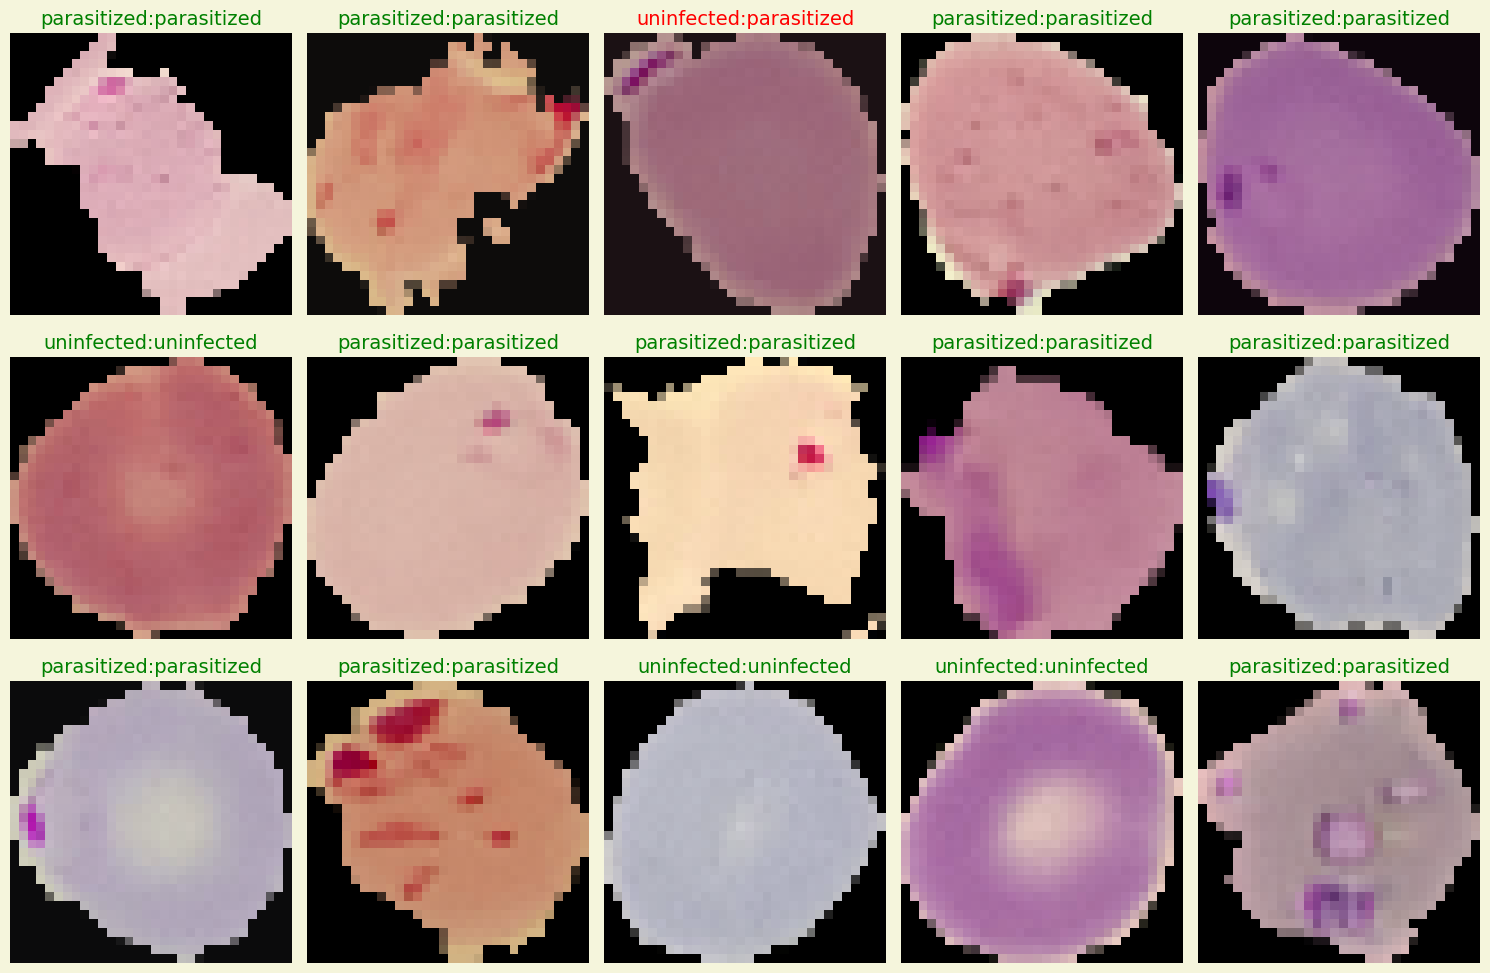

In [75]:
evaluate_model(test_ds, drop_model)

- Confusion matrix.

In [76]:
predicted_labels = drop_model.predict(test_ds)

predicted_labels = [1 if prob >= 0.5 else 0 for prob in predicted_labels]

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Saving figure confusion matrix_v_1_01


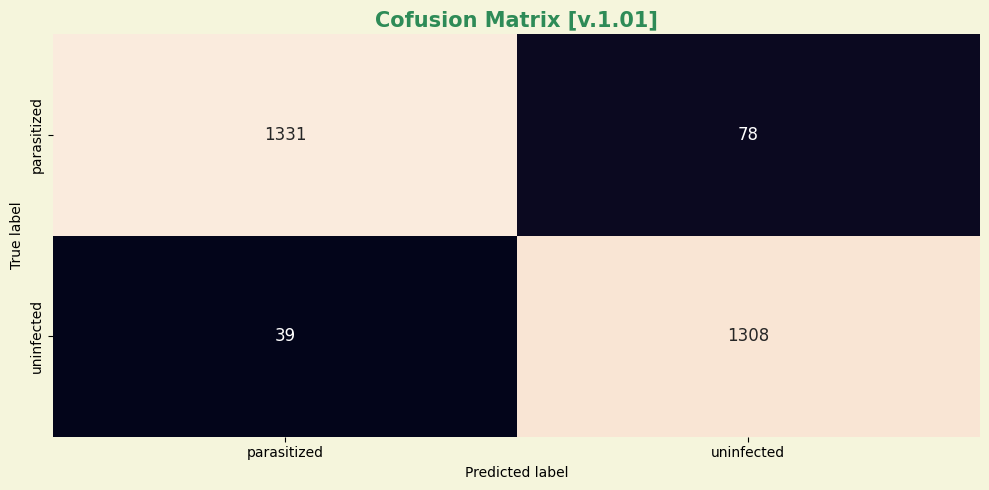

In [78]:
class_names = info.features['label'].names
ground_truth_labels = []

for image_batch, label_batch in test_ds:
    for label in label_batch:
        ground_truth_labels.append(label.numpy())
        
ground_truth = np.array(ground_truth_labels)

cm = tf.math.confusion_matrix(labels=ground_truth, predictions=predicted_labels)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d',cbar=False, annot_kws={"size": 12},
           xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Cofusion Matrix [v.1.01]", weight='bold', size=15, color='seagreen')
save_fig("confusion matrix_v_1_01")
plt.show()

In [79]:
save_model(drop_model, "malaria_v_1_01.h5")

Saving model malaria_v_1_01.h5


In [94]:
saved_model = tf.keras.models.load_model("/kaggle/working/models/malaria_v_1_01.h5")
score = saved_model.evaluate(valid_ds)
print(f"Model Accuracy: {score[1] * 100:.3f}")

20/87 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9611 - loss: 0.1489

W0000 00:00:1715551779.206331     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9599 - loss: 0.1367
Model Accuracy: 95.755


W0000 00:00:1715551780.174669     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
